#### Assignment #4 Question 3 - Adiabatic shocks : numerical exercise 

@authors: Alexandra Rochon, Olivia Locke 25/03/24

In [7]:
import numpy as np
import matplotlib.pyplot as pl
import math
from IPython.display import display, clear_output
import imageio
from PIL import Image
import io

Remember that you are evolving $\rho$, $\rho_u$ and $\rho_e$tot (density, momentum per volume, total energy per volume).
Always start your code by setting up the grid and time resolution, relevant constants in the problem, initial conditions, and configuring the plots.
For the initial condition, apply a Gaussian perturbation 𝛿(𝜌𝑒tot) to energy such that 𝜌𝑒tot(𝑡=0)=1+$\delta$(𝜌𝑒tot). Set the perturbation amplitude and width appropriate for a strong shock. Set 𝜌(𝑡=0)=1 and 𝑢(𝑡=0)=0.
You will have to keep track of pressure 𝑃 and sound speed 𝑐𝑠. Think about how you can estimate these two quantities from 𝜌, 𝜌𝑢, and 𝜌𝑒tot.
Consider defining a function for taking care of advection since you will have to apply donor cell advection to all three fluid equations.
Code stability depends on the order of computation. Here is my recommendation:
1. Compute the advection velocity at the cell interfaces and at the simulation boundaries.
2. Advect density, then momentum.
3. Compute pressure and apply the pressure gradient force to the momentum equation.
4. You will have to correct for the pressure gradient force at the simulation boundaries for the momentum equation.
5. Re-calculate the advection velocities.
6. Advect energy.
7. Re-compute pressure and apply the corresponding source term to the energy equation.
8. Again, correct for the source term at the simulation boundaries for the energy equation.
9. Before updating your plot, re-calculate pressure and sound speed.

In [2]:
# set up grid
Ngrid = 50

# set up steps
Nsteps = 50000 
dt = 0.0001
dx = 1.0

# constants
gamma = 5/3

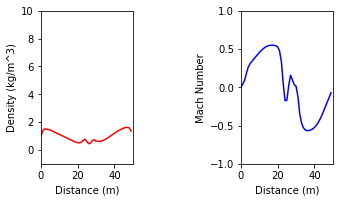

In [15]:
# define and name steps for easy future use
N = Ngrid
N_minus_1 = N
N_plus_1 = N+1
N_ = N+1
N_1 = N
N_2 = N-1
N_3 = N-2

# set up arrays for calculations
x = np.arange(0., N*dx, dx)  # x distance variable
f1 = np.ones(N)              # f1 = rho       
f2 = np.zeros(N)             # f2 = rho * u   
f3 = np.ones(N)              # f3 = rho * energy_total 
u = np.zeros(N+1)            # u = advective velocity
Jflux = np.zeros(N+1)        # array for temporary calc of flux thru cells

# calculate a gaussian with (a=amp, b=mean, c=stddev)
a=300
b=N*dx/2.0
c=5.0
def gaussian(x):
    return a*math.exp(-(x-b)**2.0/c**2.0)

# add gaussian pertibation to f3 (energy)
for xx in range(0,N_1):
    f3[xx] = f3[xx]*(1.0 + gaussian(xx*dx))

P = (gamma-1) * f1 * (f3/f1 - (f2/f1)**2/2)
Cs = np.sqrt(gamma * P/f1)
Mach = u[0:N] / Cs

# Set up plot
pl.ion()
fig, axes = pl.subplots(1, 2)

# we will be updating these plotting objects
plt1, = axes[0].plot(x, f1, 'r-')
plt2, = axes[1].plot(x, Mach, 'b-') 

# set axes limits
axes[0].set_xlim([0,N*dx])
axes[1].set_xlim([0,N*dx])
# axes[0].set_ylim([0.9998,1.0005])
axes[0].set_ylim([-1,10])
axes[1].set_ylim([-1,1])
axes[0].set_xlabel('Distance (m)')
axes[1].set_xlabel('Distance (m)')
axes[0].set_ylabel('Density (kg/m^3)')
axes[1].set_ylabel('Mach Number')
fig.tight_layout(pad=5.0)
fig.canvas.draw()

count = 0
plot_images = []

# Evolution
while count < Nsteps:
    
    ### First numerical step (n + 1/2)  -  NO SOURCE Term
    
    # Calculate velocity u at the cell centers  
    # u[0] = u[N] = 0 
    u[1:N_1] = 0.5*( f2[0:N_2]/f1[0:N_2] + f2[1:N_1]/f1[1:N_1] )
    
    # Calculate flux for f1 = rho
    # Jflux[0] = Jflux[N] = 0
    for i in range(1,N_1):  # 1..N-1
        if (u[i] > 0.0):
            Jflux[i] = u[i]*f1[i-1]
        else:
            Jflux[i] = u[i]*f1[i]
 
    # calculate f1 function; continuity equation   "Conservation of Mass"
    f1[0:N_1] = f1[0:N_1] - dt/dx * ( Jflux[1:N_] - Jflux[0:N_1] )
    
    # Calculate flux for f2 = rho*u = momentum
    # note Jflux[0] = Jflux[N] = 0
    for i in range(1,N_1):
        if (u[i] > 0.0):
            Jflux[i] = u[i]*f2[i-1]
        else:
            Jflux[i] = u[i]*f2[i]
         
    # calculate f2 function; Euler equation   "Conservation of Momentum"
    f2[0:N_1] = f2[0:N_1] - dt/dx * ( Jflux[1:N_] - Jflux[0:N_1] )
 
    # pressure attempt
    P = (gamma - 1) * f1 * (f3/f1 - (f2/f1)**2 / 2)
    
    # calculate source term for momentum
    f2[1:N_2] = f2[1:N_2] -  (dt/(2*dx)) * (P[2:N_1] - P[0:N_3])
    
    # boundary conditions 
    f2[0] = f2[0] - 0.5* dt/dx * (P[1] - P[0])
    f2[N-1] = f2[N-1] - 0.5* dt/dx * (P[N-1] - P[N-2])
    
    # re-calculate advection velocities 
    u[1:N_1] = 0.5*( f2[0:N_2]/f1[0:N_2] + f2[1:N_1]/f1[1:N_1] )
    
    ##  energy advection 
    for i in range(1,N_1): 
        if (u[i] > 0.0):
            Jflux[i] = u[i]*f3[i-1]
        else:
            Jflux[i] = u[i]*f3[i]
 
    # calculate f3 function; energy conservation
    f3[0:N_1] = f3[0:N_1] - dt/dx * (Jflux[1:N_] - Jflux[0:N_1])
    
    # pressure again 
    P = (5/3-1) * f1 * (f3/f1 - (f2/f1)**2/2)
    
    f3[1:N_2] = f3[1:N_2] -  (dt/(2*dx)) * (P[2:N_1] * u[2:N_1] - P[0:N_3] * u[0:N_3])
    
    # boundary conditions 
    f3[0] = f3[0] - 0.5* dt/dx * (P[1]*u[1] - P[0]*u[0])
    f3[N-1] = f3[N-1] - 0.5* dt/dx * (P[N-1]*u[N-1] - P[N-2]*u[N-2])
    
    # recalculate pressure  
    P = (5/3-1) * f1 * (f3/f1 - (f2/f1)**2/2)

    # recalculate speed of sound
    Cs = np.sqrt(5/3 * P/f1)
    
    Mach = u[0:N] / Cs

    if (count % 100) == 0:
        ## update the plots
        plt1.set_ydata(f1)
        plt2.set_ydata(Mach)
    
        # Save the plot
        fig.canvas.draw()
        plot_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        plot_image = plot_image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plot_images.append(plot_image)
    
        # display plots
        display(fig)
        clear_output(wait=True)
    
        pl.pause(0.001)
    
    # add to count (for next loop through)
    count += 1

# Create a gif from saved plots
imageio.mimsave('shocks.gif', plot_images)


In [71]:
ratio = (gamma - 1) / (gamma + 1) 
print(ratio)

4.0


The ratio of densities pre/post shock is equal to ($\gamma$+1) / ($\gamma$-1). $\gamma$ is equal to 5/3. We set the inital density to 1 and the density post shock is around 3, for a ratio of 1/3. The computed value is 1/4, so they are similar. Thus the compression factor for a strong shock is close to ($\gamma$+1) / ($\gamma$-1). See the gif for reference.

The width of the shocks $\Delta$x scales like viscosity over velocity or $\lambda$ mean free path over Mach number. From the plot, the width is 15. 